In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import batch_norm
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context
plt.rcParams['text.usetex'] = True

In [2]:
from pathlib import Path

dt_p = Path('data/mnist')

batch_size = 128
n_channels, w, h = 1, 28, 28

classes = [str(i) for i in range(10)]
n_labels = len(classes)

transform = transforms.Compose(
    [transforms.ToTensor()])

    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


trainset = datasets.MNIST(root=f'{dt_p.absolute()}/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.MNIST(root=f'{dt_p.absolute()}/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



In [3]:


class Net(nn.Module):
    def __init__(self, input_size=28):  # Add input size for flexibility
        super().__init__()
        self.conv1a = nn.Conv2d(1, 32, 3, padding=0)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=0)
        self.conv2a = nn.Conv2d(32, 64, 3, padding=0)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the number of features dynamically
        self._to_linear = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(self._to_linear, 200)
        self.fc2 = nn.Linear(200, 10)

        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(200)  # Now correctly applied

    def _get_conv_output(self, size):
        """Helper function to compute the output size after convolutions"""
        x = torch.zeros(1, 1, size, size)  # Create a dummy tensor
        x = self.pool(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool(F.relu(self.conv2b(F.relu(self.conv2a(x)))))
        return x.numel()

    def forward(self, x):
        x = self.activation(self.conv1a(x))
        x = self.activation(self.conv1b(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.activation(self.conv2a(x))
        x = self.activation(self.conv2b(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = self.flatten(x)  # Flatten before FC layers
        x = self.activation(self.fc1(x))
        x = self.batchnorm(x)
        x = self.fc2(x)
        # CrossEntropyLoss already applied softmax
        return x  # Remove softmax if using CrossEntropyLoss

    
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Playing on {device}")

Playing on cuda


In [4]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
adam = torch.optim.AdamW(model.parameters(), lr=0.001)

  2%|▏         | 1/50 [00:02<02:11,  2.69s/it]

 22%|██▏       | 11/50 [00:27<01:36,  2.46s/it]

 42%|████▏     | 21/50 [00:50<01:05,  2.27s/it]

 62%|██████▏   | 31/50 [01:13<00:43,  2.29s/it]

 82%|████████▏ | 41/50 [01:36<00:20,  2.25s/it]

100%|██████████| 50/50 [01:56<00:00,  2.34s/it]


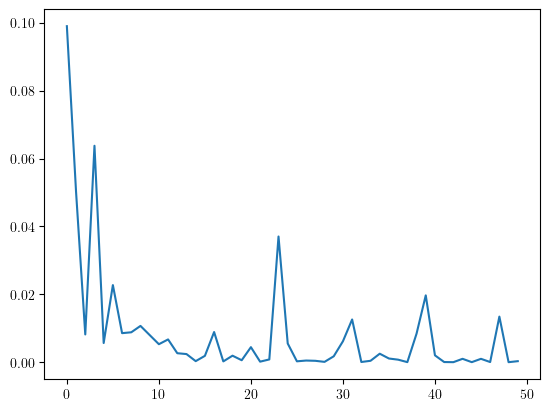

In [5]:
import time
losses = []

for e in tqdm(range(50)):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_hat_dist = model(images)
        adam.zero_grad()
        loss = criterion(labels_hat_dist, labels)
        loss.backward()
        adam.step()
    losses.append(loss.item())
    if e % 10 == 0:
        print(f"Epoch {e} loss: {loss.item()}", end="\r")

plt.plot(losses)
plt.show()

PATH = f'C:/Users/aless/Repos/Rug/P3/Xai/Distillation_experiments/models/{time.strftime("%m%d-%H%M%S")}.pth'
torch.save(model.state_dict(), PATH)


## Direction Sensitivity Estimation
This section aims to experiment with the first of the two tasks [(Papernot et al., 2016)](https://arxiv.org/abs/1511.04508): Direction Sensitivity Estimation. Given a sample $X$ we want to test a trained model $F$ on perturbated version of the sample (i.e. $\delta X$) to find the dimensions of $X$ that will produce expected adversarial behavior (misclassification) with the *smallest* perturbation. We formalize the problem as a linear program:
$$\arg\min_{\delta X}||\delta X|| \text{ s.t. } F(X+\delta X) = Y^*$$
where $Y^*$ is the adverserial class indicator vector. Following [(Goodfellow et al., 2014)](https://arxiv.org/pdf/1412.6572) we calculate the sign of the gradient (i.e. `step = images.grad.sign()`) and after defining a perturbation of $\delta = 0.2$ and calculate the loss for both vanilla and perturbated sample to study the loss.

In [6]:
images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

# Inside train loop
images.requires_grad = True
labels_hat_dist = model(images)
loss = criterion(labels_hat_dist, labels)
loss.backward()

print("Original loss", loss.item())


step = images.grad.sign()
perturbed_image = images + 0.2*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)
print("Adv loss", loss.item())

Original loss 0.03927202522754669
Adv loss 0.9252970218658447


GroundTruth:  7     0     8     8     9     6     9     0     8     1     7     1     3     3     2     2     1     0     1     4     7     5     8     7     0     1     0     5     7     9     6     9     6     7     0     9     1     0     4     6     9     6     2     7     6     7     6     5     3     4     2     3     4     8     0     1     7     8     9     0     8     7     4     7     6     7     3     6     3     1     7     7     1     4     9     8     3     7     3     4     5     4     1     0     3     4     3     8     3     0     9     7     1     4     0     3     6     3     8     1     4     1     9     5     5     9     1     4     5     0     0     1     2     1     2     3     7     8     2     1     0     1     3     7     3     8     3     2    
Predicted:  7     0     8     8     9     6     9     0     8     1     7     1     3     3     2     2     1     0     1     4     7     8     8     9     0     1     0     5     7     9     4     9     6     7     0 

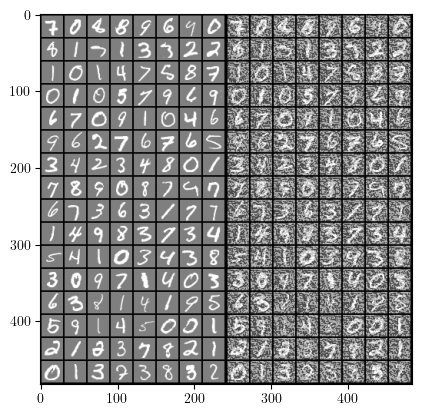

In [7]:
DELTA = 0.2

dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images / 2 + 0.5

limit = 0

losses = []

grid = utils.make_grid(images[:(len(labels)-limit)])
# print images

gt = [f'{classes[labels[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('GroundTruth: ', ' '.join(gt))

#net.load_state_dict(torch.load(PATH, weights_only=True))

images, labels = images.to(device), labels.to(device)

images.requires_grad = True

outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()

losses.append(loss.item())

_, org_predicted = torch.max(outputs, 1)

org = [f'{classes[org_predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('Predicted: ', ' '.join(org))

step = images.grad.sign()

#print(step)

perturbed_image = images + DELTA*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

grid_n = utils.make_grid(perturbed_image[:(len(labels)-limit)])

grod = np.concatenate((np.transpose(grid, (1, 2, 0)),np.transpose(grid_n.cpu(), (1, 2, 0))), axis=1)
# print images
plt.imshow(grod)


labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)

losses.append(loss.item())

_, predicted = torch.max(labels_hat_dist, 1)

adv = [f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]


print('Averserial: ', ' '.join(adv))

errors = 0
res = []
for o, p, a in zip(org, gt, adv):
    if o != p:
        errors += 1
        res.append('errr')
    elif o == p and o != a:
        res.append('succ')
    else:
        res.append('fail')

print(f'Attack: ', ' '.join(res))
print('\n')
print(f'Delta loss: {np.abs(losses[0]-losses[1]):.4f}\n\tOriginal loss: {losses[0]:.4f}\n\tAdversarial loss: {losses[1]:.4f}')

total=0
correct=0

for immg, labb, opred, pred in zip(perturbed_image, labels, org_predicted, predicted):
    if pred == labb and labb == opred:
        correct += 1
print(f'\nAdversary attack success rate over batch of {len(perturbed_image)} minus {errors} already misclassified samples: {(100-(100 * (correct / (len(perturbed_image)-errors)))):.2f}%\n\tDelta= {DELTA}')

<>:110: SyntaxWarning: invalid escape sequence '\d'
<>:116: SyntaxWarning: invalid escape sequence '\d'
<>:118: SyntaxWarning: invalid escape sequence '\%'
<>:123: SyntaxWarning: invalid escape sequence '\m'
<>:124: SyntaxWarning: invalid escape sequence '\d'
<>:127: SyntaxWarning: invalid escape sequence '\%'
<>:148: SyntaxWarning: invalid escape sequence '\d'
<>:110: SyntaxWarning: invalid escape sequence '\d'
<>:116: SyntaxWarning: invalid escape sequence '\d'
<>:118: SyntaxWarning: invalid escape sequence '\%'
<>:123: SyntaxWarning: invalid escape sequence '\m'
<>:124: SyntaxWarning: invalid escape sequence '\d'
<>:127: SyntaxWarning: invalid escape sequence '\%'
<>:148: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aless\AppData\Local\Temp\ipykernel_16968\3908822815.py:110: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Perturbation magnitude $\delta$')
C:\Users\aless\AppData\Local\Temp\ipykernel_16968\3908822815.py:116: SyntaxWarning: invalid escape sequence 

128 128
Misclassified samples: 0


100%|██████████| 4/4 [00:39<00:00,  9.82s/it]


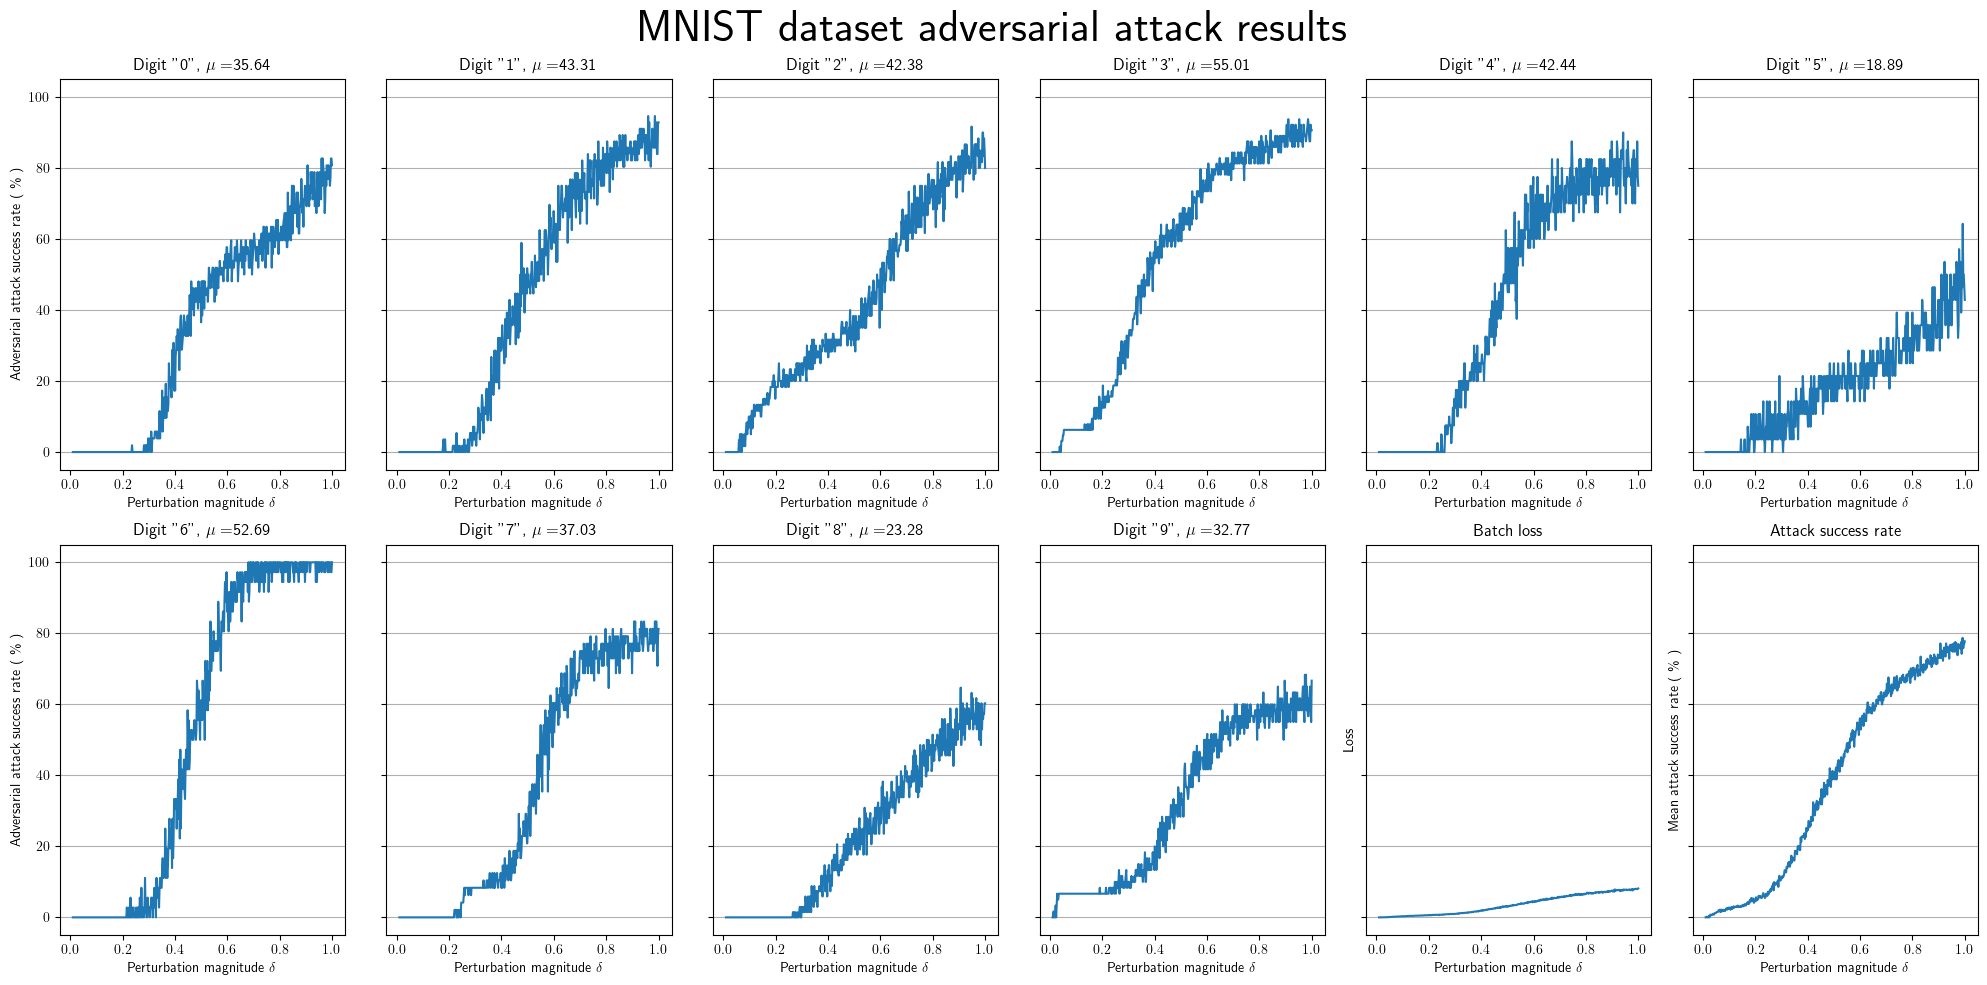

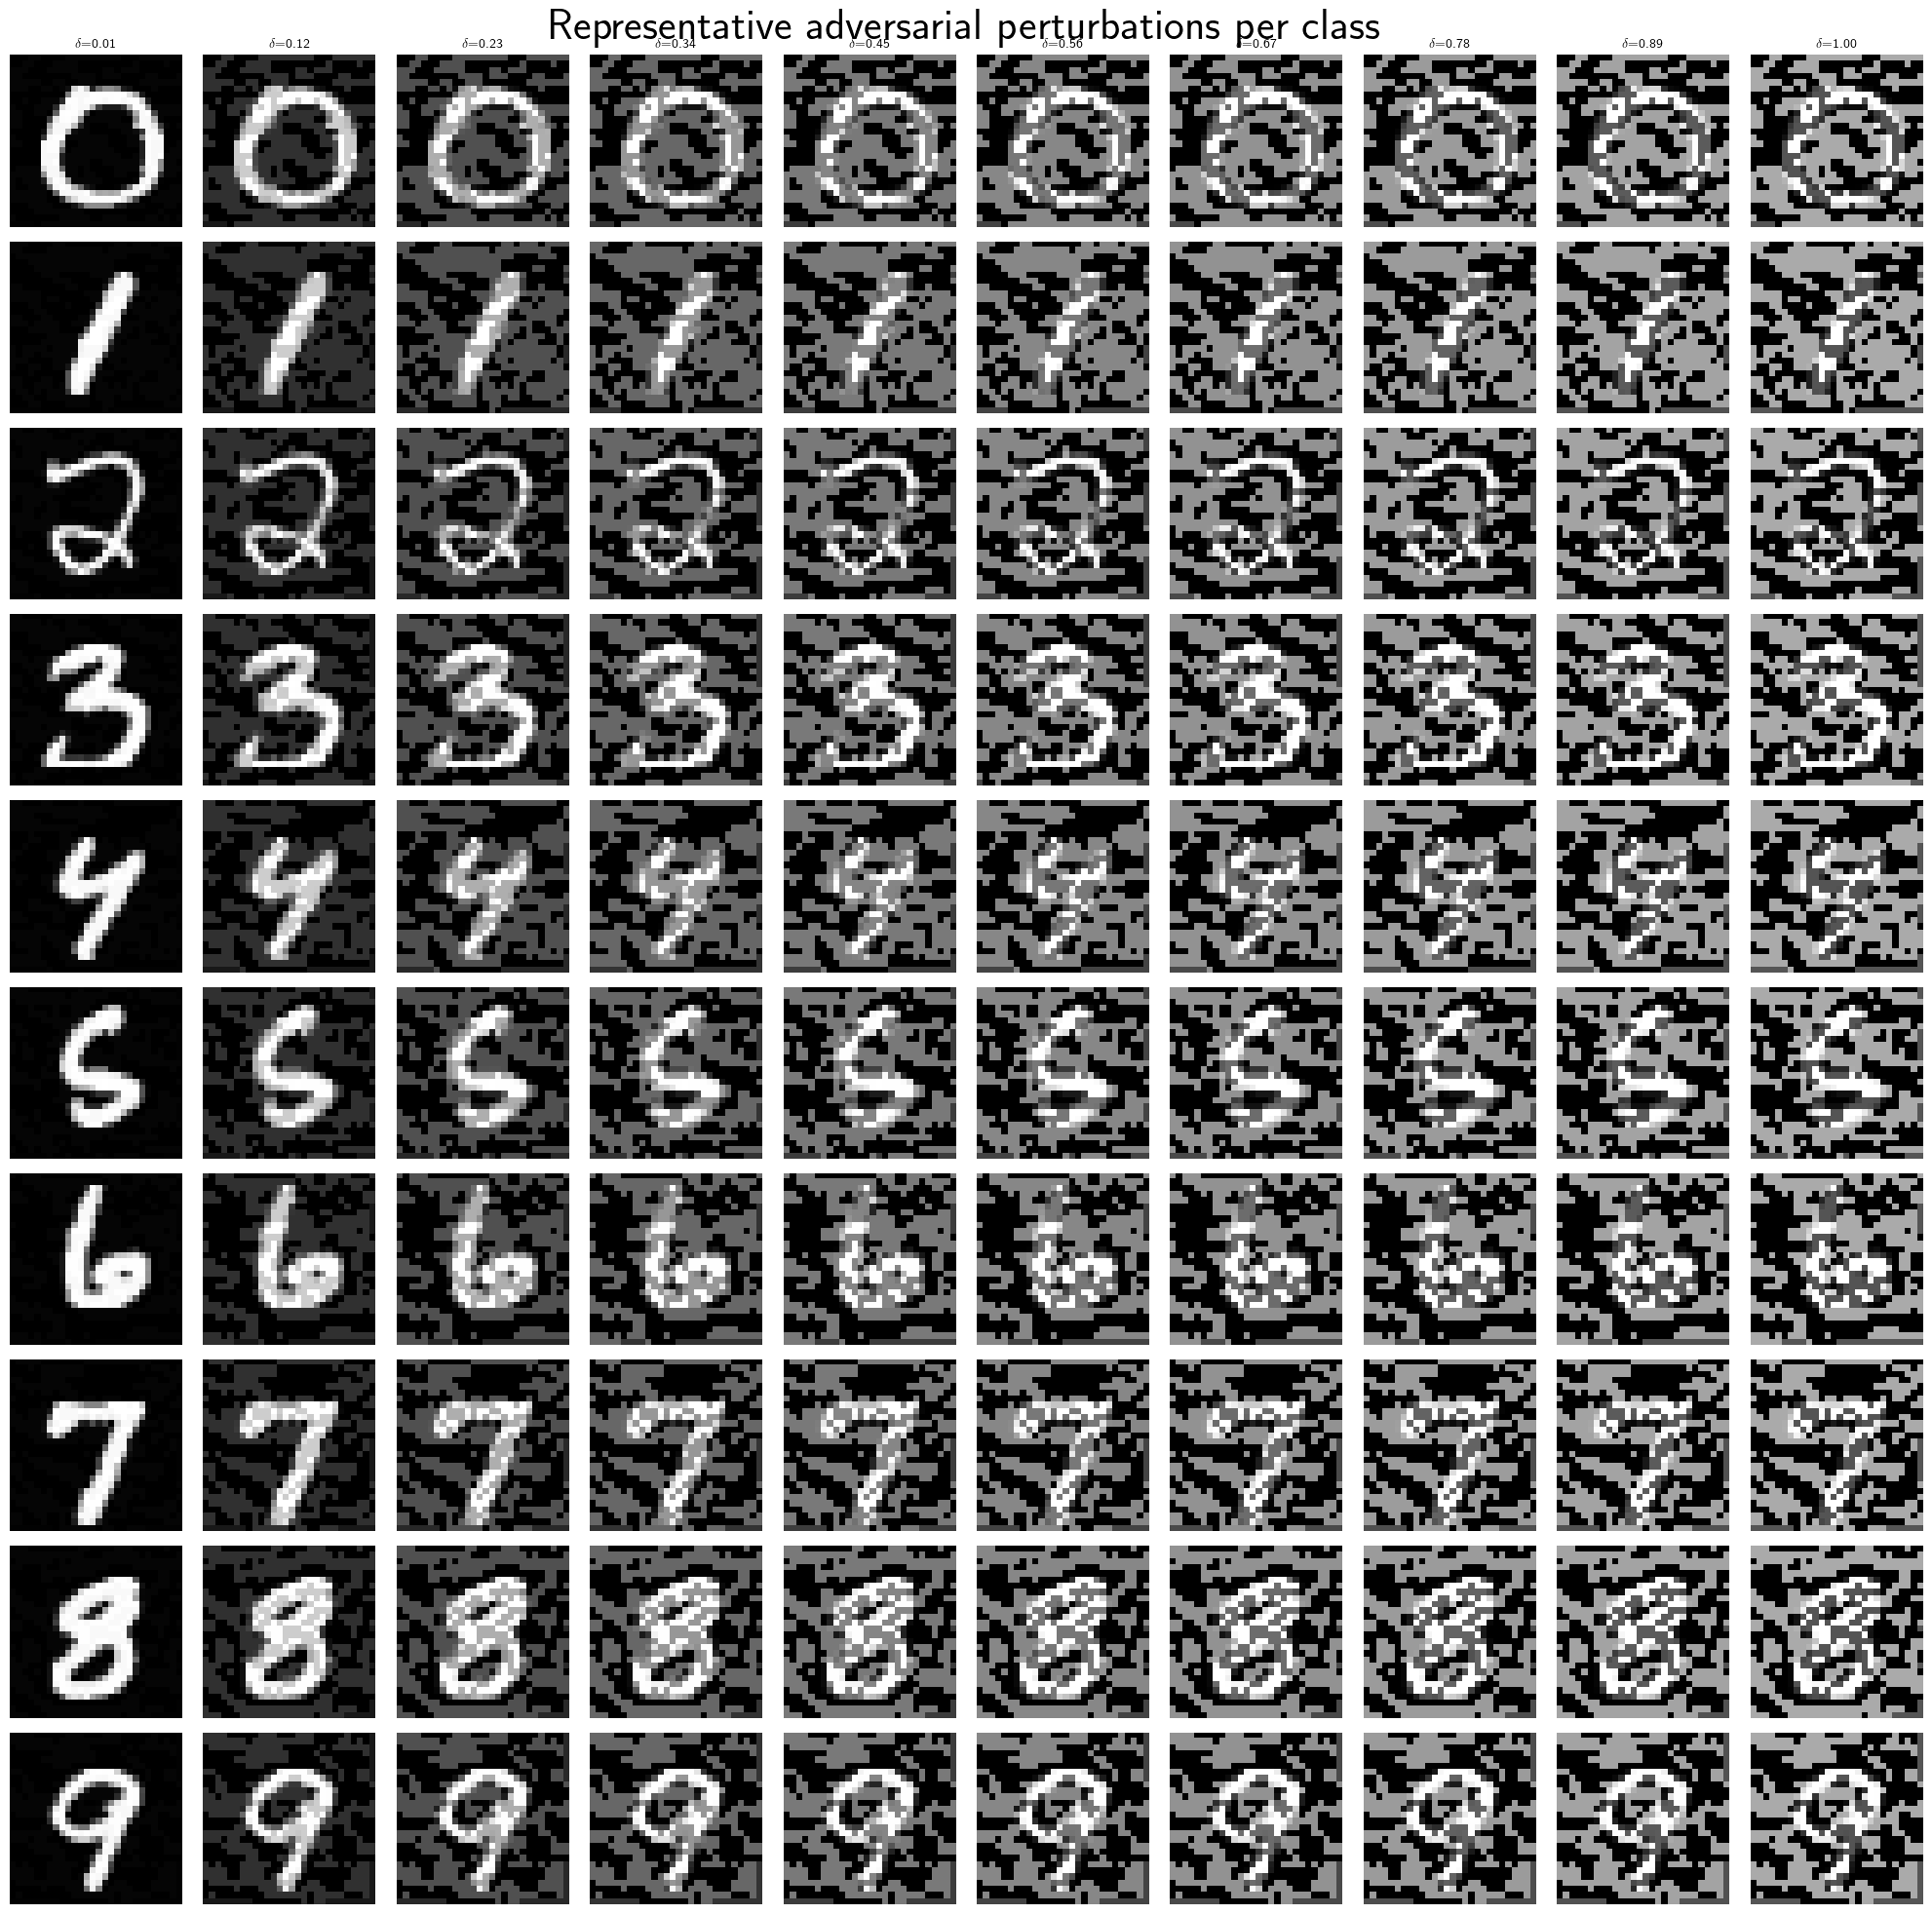

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate the delta schedule
delta_schedule = np.linspace(0.01, 1, 500)

# Import data and feed it to the model to get the gradients
dataiter = iter(trainloader)
images, labels = next(dataiter)
# images = images / 2 + 0.5  # Unnormalize images for visualization

print(len(images), len(labels))

ground_truth = [f'{classes[labels[j]]:5s}' for j in range(len(labels))]
images, labels = images.to(device), labels.to(device)
images.requires_grad = True

# Forward pass and compute loss
outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()

model.zero_grad()

step = images.grad.sign()

# Get the original predictions
_, org_predicted = torch.max(outputs, 1)

# Remove misclassified samples (to later compute meaningful per-class statistics)
misclassificated_samples = []
for i in range(len(labels)):
    if org_predicted[i] != labels[i]:
        misclassificated_samples.append(i)
print(f'Misclassified samples: {len(misclassificated_samples)}')

# ---------------------------------------------------------------------
# EXTRA STEP: Select one representative sample per class (from correctly classified ones)
# We also store its computed gradient.
representative_samples = {}  # dict mapping class name to (index, image, grad)
for i in range(len(labels)):
    if i in misclassificated_samples:
        continue
    cls = classes[labels[i]]
    if cls not in representative_samples:
        representative_samples[cls] = (i, images[i].detach(), images.grad[i].detach())
    if len(representative_samples) == len(classes):
        break

# Preselect 10 delta values (equally spaced from the delta_schedule) for visualization
delta_indices = np.linspace(0, len(delta_schedule)-1, 10, dtype=int)
selected_deltas = delta_schedule[delta_indices]

# ---------------------------------------------------------------------
# Main adversarial evaluation loop (repeated 10 times)
big_loss = []
big_acc = []
big_success = []
perturbed_hist = []

for _ in tqdm(range(4)):
    losses = []
    class_accuracies = []
    success_rate = []
    for delta in delta_schedule:
        # Compute perturbed images using the sign of the gradient (same for the whole batch)
        perturbed = images + delta * step
        perturbed = torch.clamp(perturbed, 0, 1)
        adv_labels = model(perturbed)
        loss_val = criterion(adv_labels, labels)
        losses.append(loss_val.item())

        _, adv_predicted = torch.max(adv_labels, 1)

        # Compute per-class attack success (only for correctly classified original images)
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (l, p) in enumerate(zip(labels, adv_predicted)):
                if i in misclassificated_samples:
                    continue
                else:
                    if l != p:
                        correct += 1
                        correct_pred[classes[l]] += 1
                    total_pred[classes[l]] += 1
                    total += 1

        success_rate.append(100 * correct / total)
        accu = []
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * correct_count / total_pred[classname]
            accu.append(accuracy)
        class_accuracies.append(accu)
    big_loss.append(losses)
    big_acc.append(class_accuracies)
    big_success.append(success_rate)

# ---------------------------------------------------------------------
# Plot the adversarial evaluation curves
fig, axes = plt.subplots(2, int((len(classes)+2)/2), figsize=(20, 10), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i == len(classes):
        ax.plot(delta_schedule, np.mean(big_loss, axis=0))
        ax.set_title('Batch loss')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        ax.set_ylabel('Loss')
    elif i == len(classes)+1:
        ax.plot(delta_schedule, np.mean(big_success, axis=0))
        ax.set_title('Attack success rate')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        ax.set_ylabel('Mean attack success rate ( \% )')
    else:
        # For each digit, extract the corresponding success rate curves over delta
        accs = [acc[i] for acc in np.mean(big_acc, axis=0)]
        ax.plot(delta_schedule, accs)
        ax.set_title(f'Digit "{classes[i]}", $\mu = ${np.mean(accs):.2f}')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        if i % ((len(classes)+2)/2) == 0:
            ax.set_ylabel('Adversarial attack success rate ( \% )')
fig.suptitle('MNIST dataset adversarial attack results', fontsize=32)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Create a new figure for the representative perturbed images
# We display a grid: one row per digit and one column per selected delta value.
fig2, axes2 = plt.subplots(nrows=len(classes), ncols=len(selected_deltas), figsize=(20, 20))
# Order classes 
sorted_classes = sorted(representative_samples.keys(), key=lambda x: int(x))
for row_idx, cls in enumerate(sorted_classes):
    idx, img, grad_img = representative_samples[cls]
    for col_idx, delta in enumerate(selected_deltas):
        # Compute the perturbed image for this representative sample
        perturbed_img = img + delta * grad_img.sign()
        ax = axes2[row_idx, col_idx]
        ax.imshow(perturbed_img.squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
        # Optionally, add the delta value as a title in the first row
        if row_idx == 0:
            ax.set_title(f'$\delta$={delta:.2f}', fontsize=10)
    # Label the first column with the class name
    axes2[row_idx, 0].set_ylabel(f'{cls}', fontsize=12, rotation=0, labelpad=20)

fig2.suptitle('Representative adversarial perturbations per class', fontsize=32)
plt.tight_layout()
plt.show()


In [6]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []
with torch.no_grad():
    for _ in tqdm(range(10)):
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)

print(f'Accuracy of the network on the 10000 test images: {np.mean(accuracies):.3f} %')

100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

Accuracy of the network on the 10000 test images: 99.489 %


<>:147: SyntaxWarning: invalid escape sequence '\d'
<>:154: SyntaxWarning: invalid escape sequence '\d'
<>:156: SyntaxWarning: invalid escape sequence '\%'
<>:162: SyntaxWarning: invalid escape sequence '\m'
<>:163: SyntaxWarning: invalid escape sequence '\d'
<>:166: SyntaxWarning: invalid escape sequence '\%'
<>:188: SyntaxWarning: invalid escape sequence '\d'
<>:147: SyntaxWarning: invalid escape sequence '\d'
<>:154: SyntaxWarning: invalid escape sequence '\d'
<>:156: SyntaxWarning: invalid escape sequence '\%'
<>:162: SyntaxWarning: invalid escape sequence '\m'
<>:163: SyntaxWarning: invalid escape sequence '\d'
<>:166: SyntaxWarning: invalid escape sequence '\%'
<>:188: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aless\AppData\Local\Temp\ipykernel_10908\1136972362.py:147: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Perturbation magnitude $\delta$')
C:\Users\aless\AppData\Local\Temp\ipykernel_10908\1136972362.py:154: SyntaxWarning: invalid escape sequence 

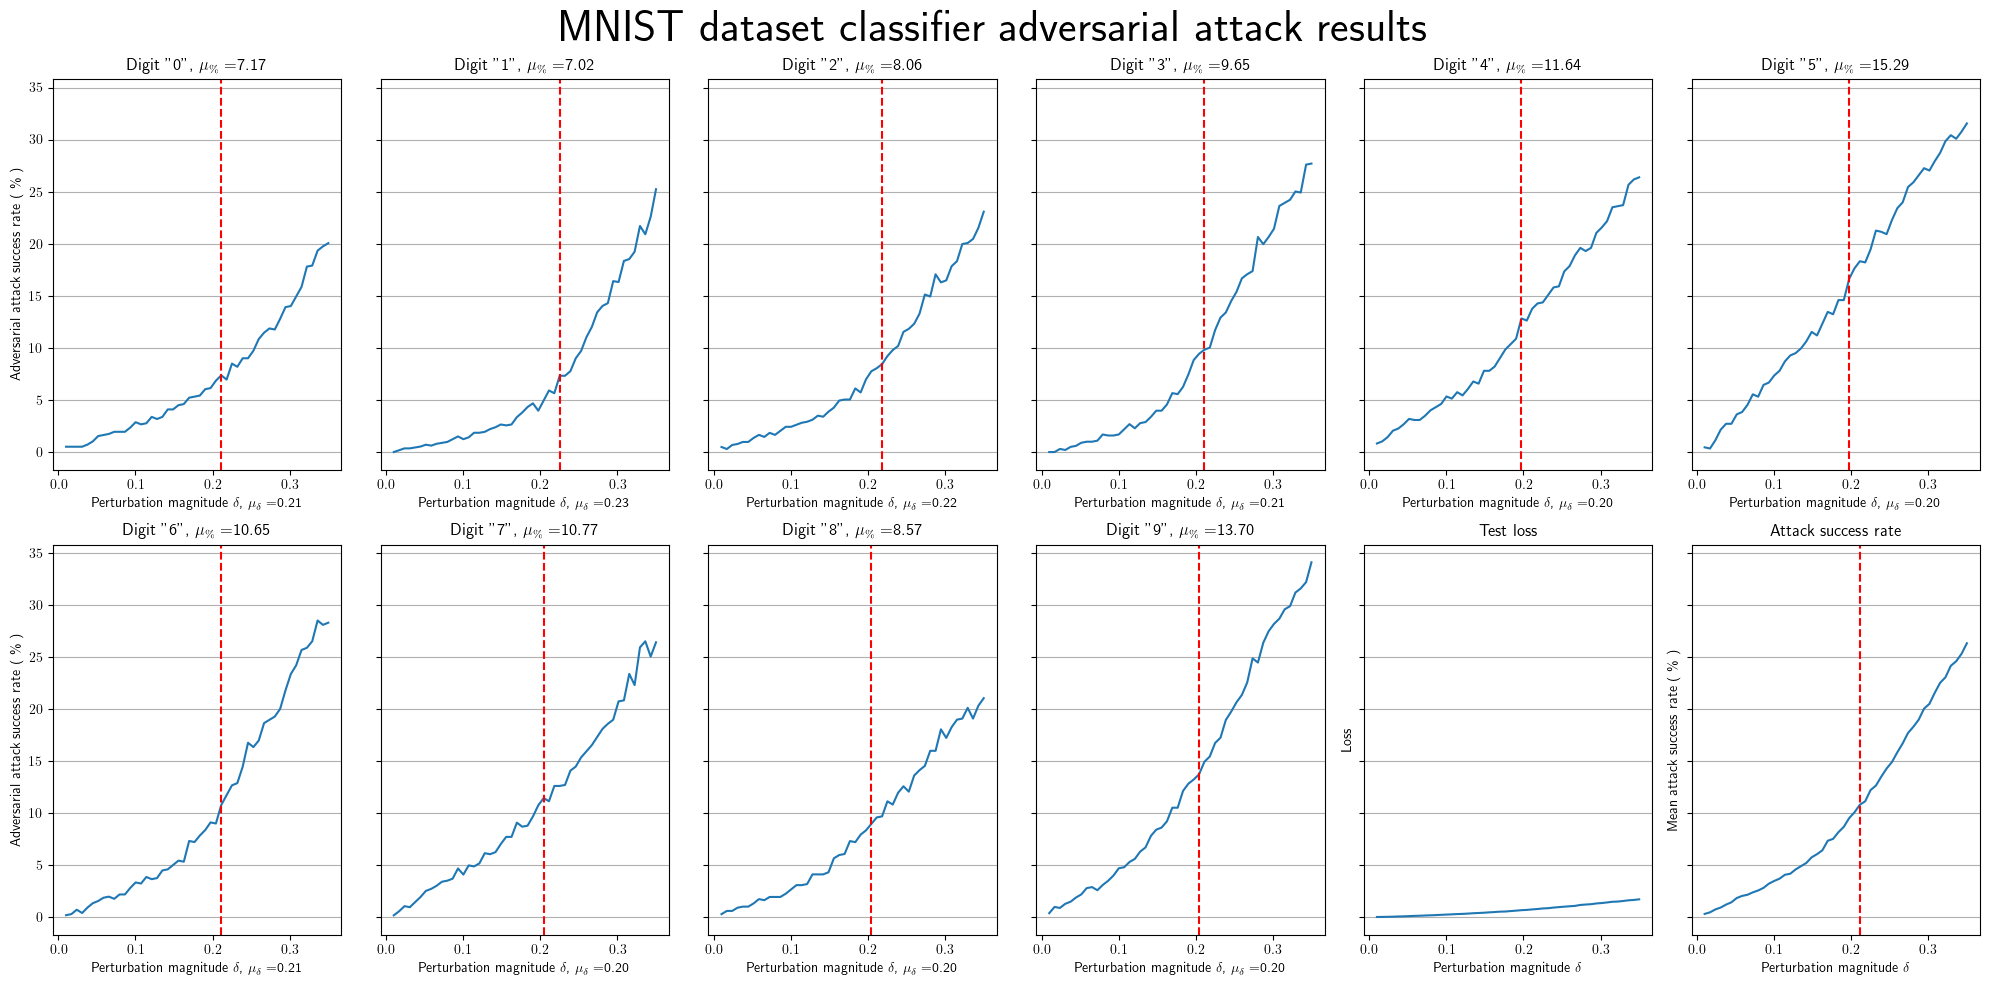

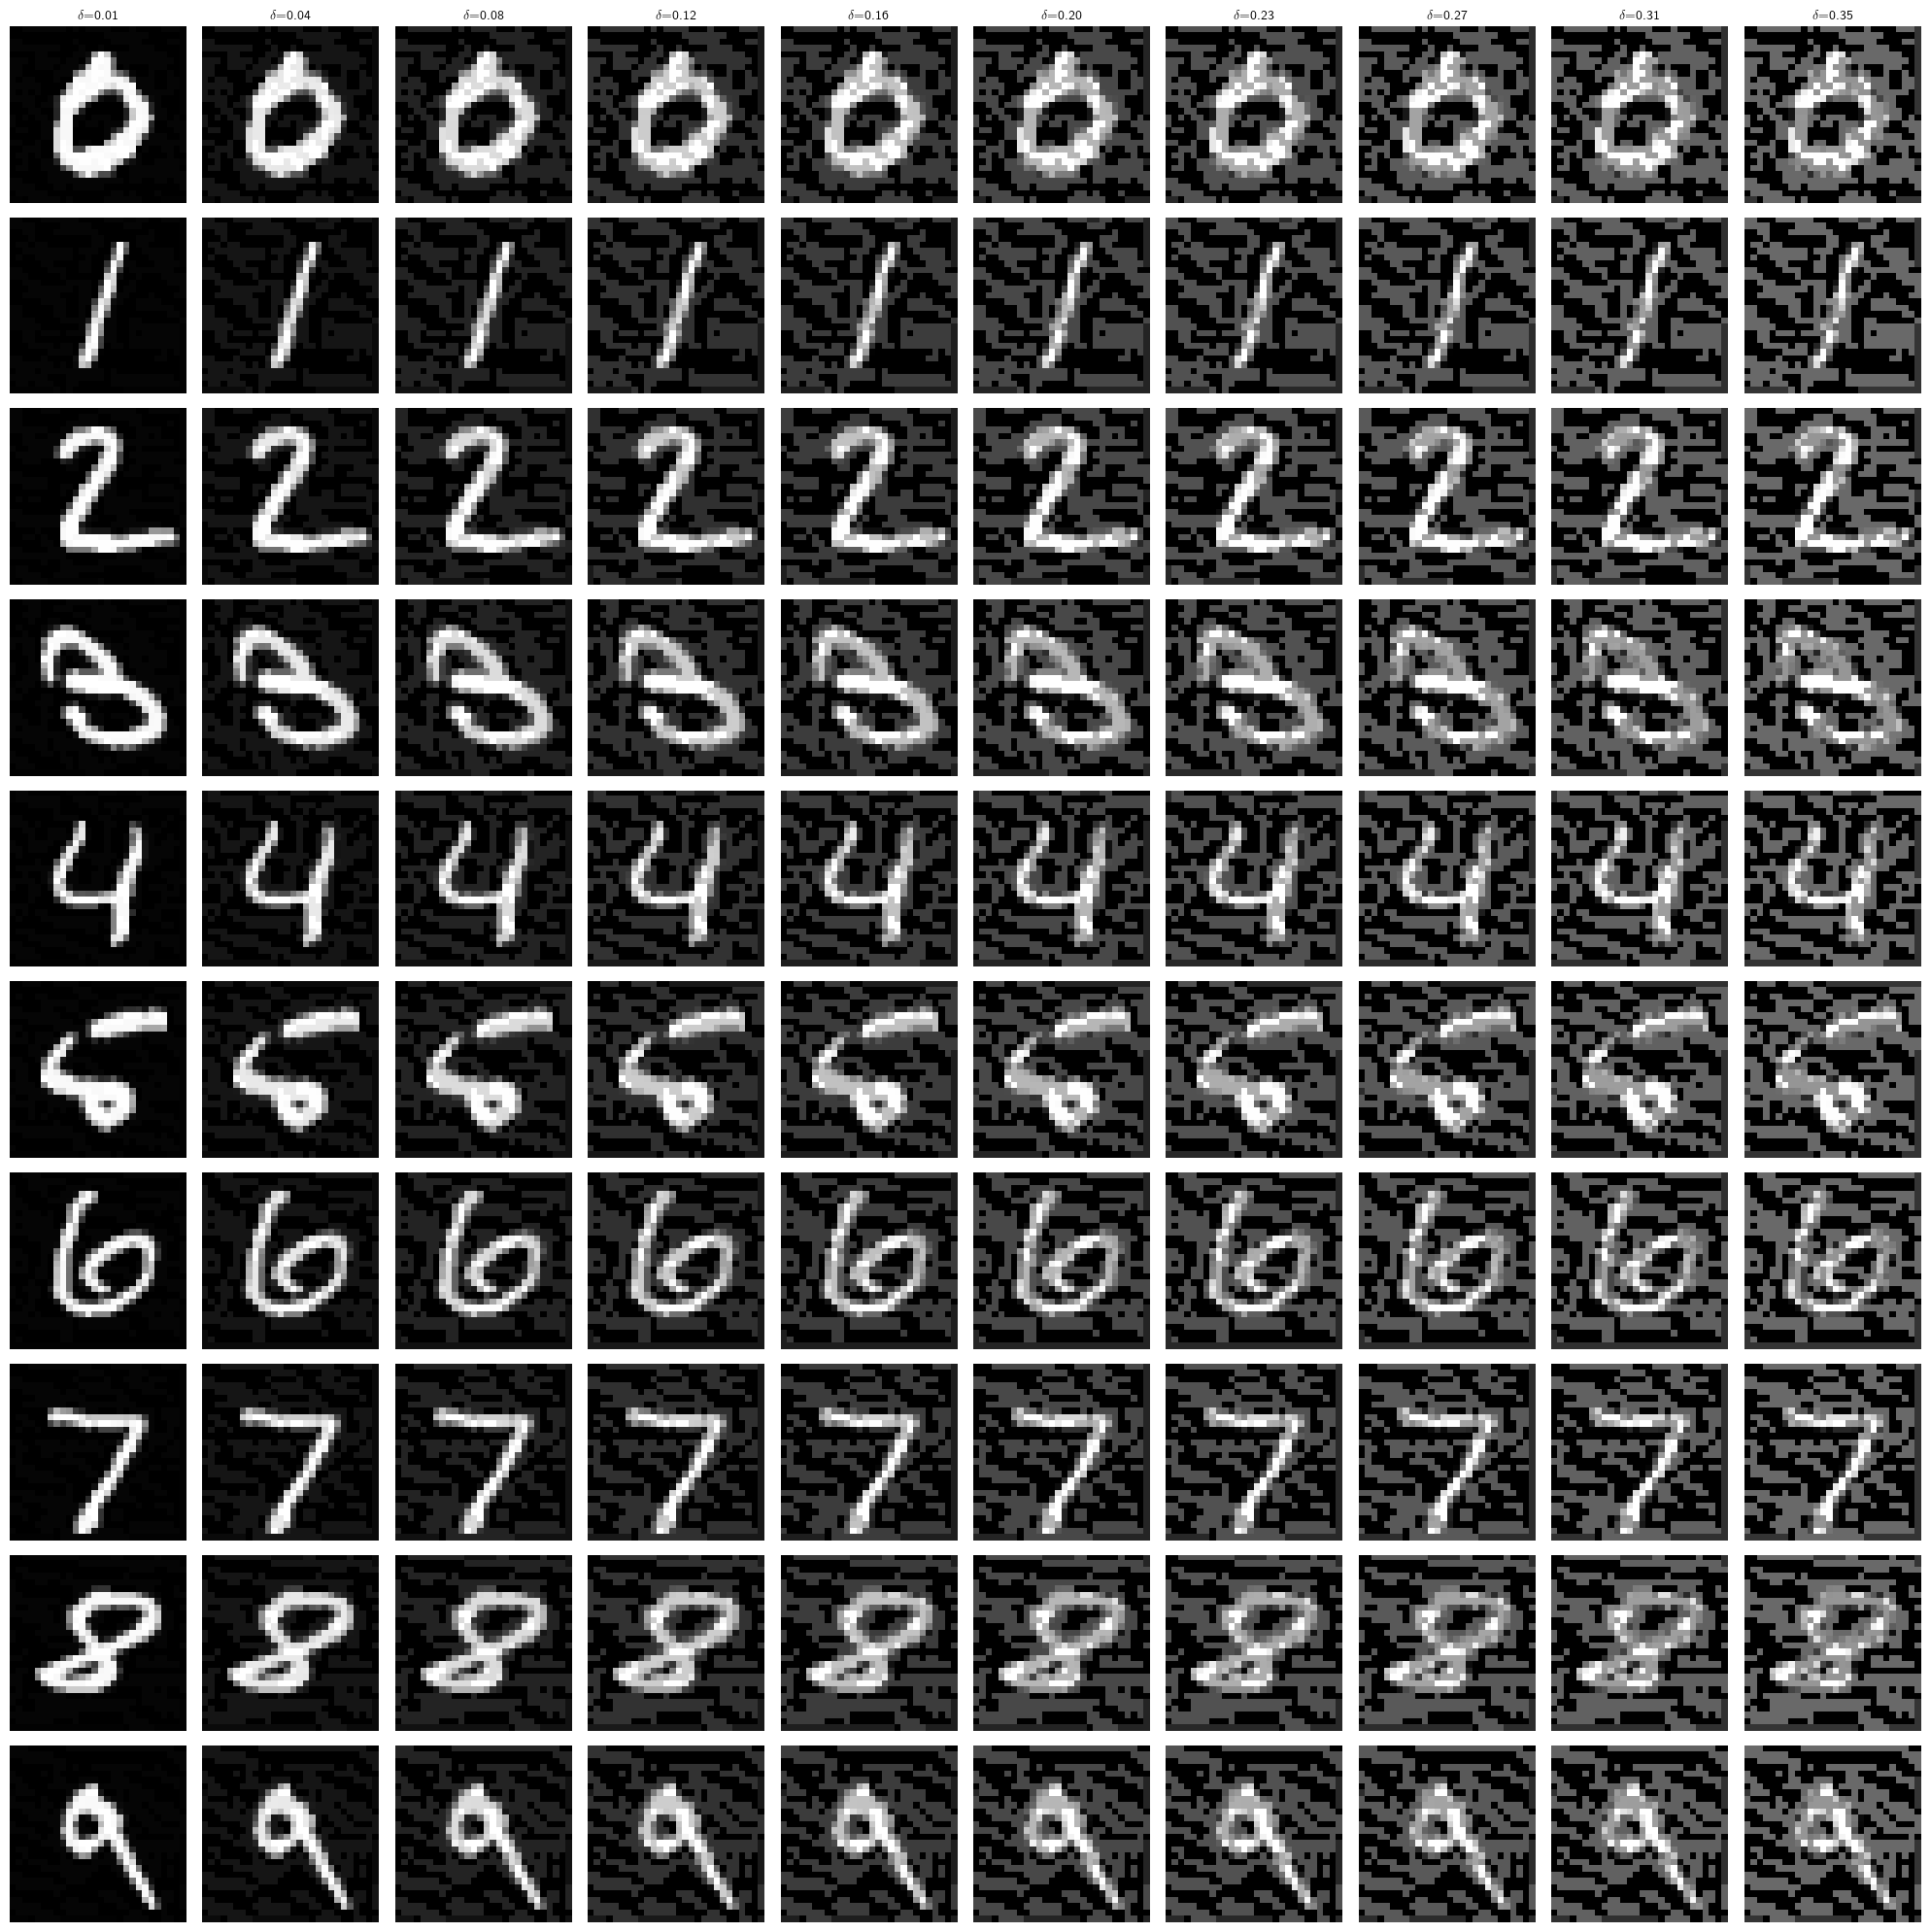

In [14]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate the delta schedule
delta_schedule = np.linspace(0.01, 0.35, 50)

# define delta limits for visualization
horiZ = 0.35

# ---------------------------------------------------------------------
# STEP 1: Select representative samples from the whole test set.
# (We pick one correctly classified sample per class along with its gradient)
representative_samples = {}  # dict mapping class name to (image, grad)
for images, labels in tqdm(testloader, desc='Batch progress'):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    
    # Iterate through the batch and select the first correct sample per class
    _, org_predicted = torch.max(outputs, 1)
    for i in range(len(labels)):
        if org_predicted[i] == labels[i]:
            cls = classes[labels[i].item()]  # assume classes is a list of class names
            if cls not in representative_samples:
                # store the image and its gradient (detach to avoid tracking)
                representative_samples[cls] = (images[i].detach(), images.grad[i].detach())
        if len(representative_samples) == len(classes):
            break
    if len(representative_samples) == len(classes):
        break

# Preselect 10 delta values (equally spaced from the delta_schedule) for visualization
delta_indices = np.linspace(0, len(delta_schedule)-1, 10, dtype=int)
selected_deltas = delta_schedule[delta_indices]

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    return delta_schedule[idx]

# ---------------------------------------------------------------------
# STEP 2: Main adversarial evaluation loop over the whole test set.
# We compute (for each iteration) the gradients for all test samples and then for each delta
# evaluate the attack success rate (only on originally correctly classified images)
big_loss = []
big_acc = []
big_success = []

# Outer loop (repeat evaluation several times, as in your original code)
for _ in tqdm(range(1)):
    # Accumulate images, labels and gradients from all test batches
    all_images_list = []
    all_labels_list = []
    all_gradients_list = []
    
    for images, labels in tqdm(testloader, desc='Batch progress'):
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        
        all_images_list.append(images.detach())
        all_labels_list.append(labels.detach())
        all_gradients_list.append(images.grad.detach())
    
    # Concatenate the results to get the full test set
    all_images = torch.cat(all_images_list, dim=0)
    all_labels = torch.cat(all_labels_list, dim=0)
    all_gradients = torch.cat(all_gradients_list, dim=0)
    
    # Compute original predictions on the entire test set
    with torch.no_grad():
        outputs = model(all_images)
        org_predicted = outputs.argmax(dim=1)
    
    # Create a boolean mask for samples that were correctly classified originally
    correct_mask = (org_predicted == all_labels)
    
    losses = []
    class_accuracies = []
    success_rate = []
    
    # Evaluate the adversarial attack for each delta value in the schedule
    for delta in tqdm(delta_schedule, desc='Delta schedule'):
        # Compute the adversarial examples: note the perturbation is computed with the sign of the gradient
        perturbed = all_images + delta * all_gradients.sign()
        perturbed = torch.clamp(perturbed, 0, 1)
        
        adv_outputs = model(perturbed)
        loss_val = criterion(adv_outputs, all_labels)
        losses.append(loss_val.item())
        
        adv_predicted = adv_outputs.argmax(dim=1)
        
        # Only consider samples that were correctly classified originally
        total_count = correct_mask.sum().item()
        if total_count > 0:
            # Count those that change prediction (i.e. attack “succeeds”)
            adv_incorrect = (adv_predicted[correct_mask] != all_labels[correct_mask]).sum().item()
            sr = 100 * adv_incorrect / total_count
        else:
            sr = 0
        success_rate.append(sr)
        
        # Compute per-class attack success (only for originally correctly classified samples)
        per_class_correct = {classname: 0 for classname in classes}
        per_class_total = {classname: 0 for classname in classes}
        
        for i in range(len(all_labels)):
            if correct_mask[i]:
                cls = classes[all_labels[i].item()]
                per_class_total[cls] += 1
                if adv_predicted[i] != all_labels[i]:
                    per_class_correct[cls] += 1
        
        accu = []
        for cls in classes:
            if per_class_total[cls] > 0:
                accu.append(100 * per_class_correct[cls] / per_class_total[cls])
            else:
                accu.append(0)
        class_accuracies.append(accu)
    
    big_loss.append(losses)
    big_acc.append(class_accuracies)
    big_success.append(success_rate)

# ---------------------------------------------------------------------
# STEP 3: Plot the adversarial evaluation curves

fig, axes = plt.subplots(2, int((len(classes)+2)/2), figsize=(20, 10), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i == len(classes):
        ax.plot(delta_schedule, np.mean(big_loss, axis=0))
        ax.set_title('Test loss')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        ax.set_ylabel('Loss')
    elif i == len(classes)+1:
        ax.plot(delta_schedule, np.mean(big_success, axis=0))
        ax.axvline(x=find_nearest(np.mean(big_success, axis=0),np.mean(np.mean(big_success, axis=0))), color='r', linestyle='--')
        ax.set_title('Attack success rate')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        ax.set_ylabel('Mean attack success rate ( \% )')
    else:
        # For each digit, extract the corresponding success rate curves over delta
        accs = [acc[i] for acc in np.mean(big_acc, axis=0)]
        ax.plot(delta_schedule, accs)
        ax.axvline(x=find_nearest(accs,np.mean(accs)), color='r', linestyle='--')
        ax.set_title(f'Digit "{classes[i]}", ' + '$\mu_{\%} = $' + f'{np.mean(accs):.2f}')
        ax.set_xlabel('Perturbation magnitude $\delta$, $\mu_{\delta} = $' + f'{(find_nearest(accs,np.mean(accs))):.2f}')
        ax.grid(True, axis='y')
        if i % ((len(classes)+2)/2) == 0:
            ax.set_ylabel('Adversarial attack success rate ( \% )')
fig.suptitle('MNIST dataset classifier adversarial attack results', fontsize=32)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# STEP 4: Create a new figure for the representative perturbed images.
# We display a grid: one row per digit and one column per selected delta value.
fig2, axes2 = plt.subplots(nrows=len(classes), ncols=len(selected_deltas), figsize=(20, 20))

# Order classes (assuming classes are numeric strings, e.g. '0', '1', ..., '9')
sorted_classes = sorted(representative_samples.keys(), key=lambda x: int(x))
for row_idx, cls in enumerate(sorted_classes):
    img, grad_img = representative_samples[cls]
    for col_idx, delta in enumerate(selected_deltas):
        # Compute the perturbed image for this representative sample
        perturbed_img = img + delta * grad_img.sign()
        ax = axes2[row_idx, col_idx]
        ax.imshow(perturbed_img.squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
        # Optionally, add the delta value as a title in the first row
        if row_idx == 0:
            ax.set_title(f'$\delta$={delta:.2f}', fontsize=10)
    # Label the first column with the class name
    axes2[row_idx, 0].set_ylabel(f'{cls}', fontsize=12, rotation=0, labelpad=20)
plt.tight_layout()
plt.show()


In [ ]:
import math 
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return (idx-1)/len(array)
    else:
        return (idx)/len(array)

accs = [acc[0] for acc in np.mean(big_acc, axis=0)]
print(accs)
print(f'{(find_nearest(accs,np.mean(accs))):.2f}')

[np.float64(0.5112474437627812), np.float64(1.0224948875255624), np.float64(1.329243353783231), np.float64(1.9427402862985685), np.float64(2.556237218813906), np.float64(2.965235173824131), np.float64(4.396728016359918), np.float64(5.316973415132924), np.float64(6.6462167689161555), np.float64(8.486707566462167), np.float64(9.406952965235174), np.float64(11.451942740286299), np.float64(13.496932515337424), np.float64(15.541922290388548), np.float64(18.916155419222903), np.float64(20.961145194274028), np.float64(22.903885480572598), np.float64(27.505112474437627), np.float64(28.732106339468302), np.float64(30.265848670756647), np.float64(32.20858895705521), np.float64(36.19631901840491), np.float64(38.65030674846626), np.float64(41.104294478527606), np.float64(42.535787321063395), np.float64(45.194274028629856), np.float64(46.625766871165645), np.float64(49.284253578732105), np.float64(51.02249488752556), np.float64(54.49897750511247), np.float64(53.78323108384458), np.float64(56.850715

In [12]:
print(delta_schedule[19])


0.14183673469387753
